In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import os
import pathlib
import time
from datetime import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
# Root directories
LOCAL_ROOT_DIR = '/content'
# LOCAL_ROOT_DIR = 'E:/TRAINING_OUTPUT_DIR_6'
DRIVE_ROOT_DIR = LOCAL_ROOT_DIR + '/drive'

In [3]:
from google.colab import drive
drive.mount(DRIVE_ROOT_DIR)

Mounted at /content/drive


In [ ]:
DRIVE_OUTPUT_VOCALFOLDS_DIR = DRIVE_ROOT_DIR + '/MyDrive/dcgan_pix2pix/vocalfolds/outputs/dcgan_vocalfolds'
os.makedirs(DRIVE_OUTPUT_VOCALFOLDS_DIR, exist_ok=True)

DRIVE_OUTPUT_MASKS_DIR = DRIVE_ROOT_DIR + '/MyDrive/dcgan_pix2pix/vocalfolds/outputs/generated_masks'
os.makedirs(DRIVE_OUTPUT_MASKS_DIR, exist_ok=True)

DRIVE_OUTPUT_PAIRED_IMAGES_DIR = DRIVE_ROOT_DIR + '/MyDrive/dcgan_pix2pix/vocalfolds/outputs/generated_paired_images'
os.makedirs(DRIVE_OUTPUT_PAIRED_IMAGES_DIR, exist_ok=True)

# Models dirs
PIX2PIX_MODEL_DIR = DRIVE_ROOT_DIR + '/MyDrive/dcgan_pix2pix/vocalfolds/pix2pix_model'
DCGAN_MODEL_DIR = DRIVE_ROOT_DIR + '/MyDrive/dcgan_pix2pix/vocalfolds/dcgan_model'

# Models files
# DCGAN_GENERATOR_MODEL_FILENAME = DCGAN_MODEL_DIR + '/generator/dcgan_generator_800.h5' 
DCGAN_GENERATOR_MODEL_FILENAME = DCGAN_MODEL_DIR + '/generator/dcgan_gen_256x256_latentdim_100_3150.h5' 
DCGAN_DISCRIMINATOR_MODEL_FILENAME = DCGAN_MODEL_DIR + '/discriminator/dcgan_disc_256x256_latentdim_100_3150.h5' 
# DCGAN_GENERATOR_MODEL_FILENAME = DCGAN_MODEL_DIR + '/generator/dcgan_gen_256x256_latentdim_100_9200.h5' 
# DCGAN_DISCRIMINATOR_MODEL_FILENAME = DCGAN_MODEL_DIR + '/discriminator/dcgan_disc_256x256_latentdim_100_9200.h5' 


PIX2PIX_GENERATOR_MODEL_FILENAME = PIX2PIX_MODEL_DIR + '/generator/pix2pix_gen_1325.h5' 
PIX2PIX_DISCRIMINATOR_MODEL_FILENAME = PIX2PIX_MODEL_DIR + '/discriminator/pix2pix_disc_1325.h5' 

SYNTHETIC_GENERATE_COUNT = 5

INPUT_IMAGES_TAKE_COUNT = 20

# Each image is in 256x256 size
IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3
LATENT_SPACE_DIM = 100 #512

### **Load models**

Load dcgan generator model

In [ ]:
dcgan_gen = keras.models.load_model(DCGAN_GENERATOR_MODEL_FILENAME, compile=False)

Load pix2pix generator Model

In [ ]:
pix2pix_gen = keras.models.load_model(PIX2PIX_GENERATOR_MODEL_FILENAME, compile=False)

### **Utils methods**

In [ ]:
def load_image_file(image_filename):
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image, channels=COLOR_CHANNELS)
        
    image = tf.cast(image, tf.float32)
    
    return image

In [ ]:
# Preprocess folders and images
def resize_image(image, width=IMG_WIDTH, height=IMG_HEIGHT):
    """Resize photo to specific size"""

    image = tf.image.resize(image, 
                            [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = (input_image / 127.5) - 1

    return input_image

In [ ]:
def generate_synthetic_glotis(dcgan_model=dcgan_gen, count=SYNTHETIC_GENERATE_COUNT):
  synthentic_glotis_list = []
  """
  This method returns list of synthetic glotis generated by dcgan gnerator model
  """

  for i in range(count):
    noise = tf.random.normal([1, LATENT_SPACE_DIM])
    generated_glotis = dcgan_model(noise, training=False)
    synthentic_glotis_list.append(resize_image(generated_glotis))

  return synthentic_glotis_list

### **Test loaded models**

Test dcgan generator model

In [ ]:
noise = tf.random.normal([1, LATENT_SPACE_DIM])
generated_image = dcgan_gen(noise, training=False)

plt.imshow(generated_image[0] * 0.5 + 0.5)

 Test pix2pix generator Model

In [ ]:
generated_image = resize_image(generated_image)

gen_output = pix2pix_gen(generated_image, training=True)
plt.imshow(gen_output[0] * 0.5 + 0.5)

In [ ]:
# Concatenate both models to take sinthetic masks
gen_output = pix2pix_gen(resize_image(dcgan_gen(tf.random.normal([1, LATENT_SPACE_DIM]), training=False)), training=True)
plt.imshow(gen_output[0] * 0.5 + 0.5)

##  Generate synthetics images

 Generates synthetics vocalfolds with dcgan model (just vocalfolds)

In [ ]:
import random

def generate_vocalfolds_images(dcgan_model=dcgan_gen, 
                           display=True, save_to_folder="", 
                           count=SYNTHETIC_GENERATE_COUNT):
  """
  Generates paired synthetics images (glotis and mask)
  optionally you can show and save then to a folder
  """
  folder_exists = (save_to_folder != "") and (os.path.isdir(save_to_folder))


  synthentic_glotis_list = generate_synthetic_glotis(dcgan_model, count)

  for glotis in synthentic_glotis_list:
    # prediction = pix2pix_model(glotis, training=True)
    # plt.figure(figsize=(15, 15))

    # display_list = [glotis[0], prediction[0]]
    # title = ['Synthetic Glotis', 'Synthetic Mask']

    # for i in range(2):
      # plt.subplot(1, 3, i+1)
      # plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
    
    plt.axis('off')
    figure = plt.gcf()

    if display: 
      plt.imshow(glotis[0] * 0.5 + 0.5)
      plt.show()
      

    if folder_exists:
      rnd = random.randint(10000, 99999)
      figure.savefig(save_to_folder + '/gen_vocalfold_%03d.jpg' % rnd, bbox_inches='tight')

    plt.close()

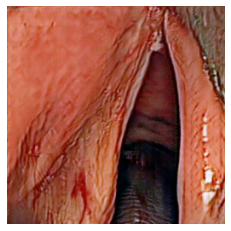

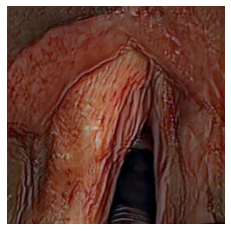

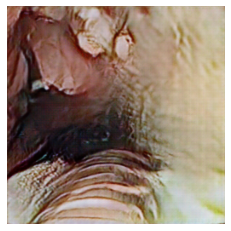

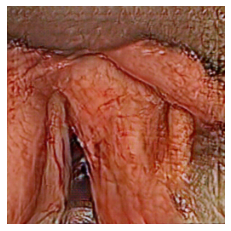

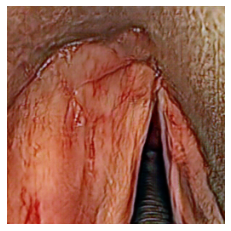

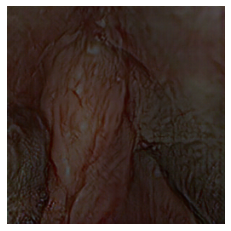

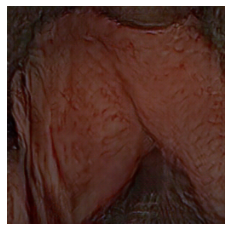

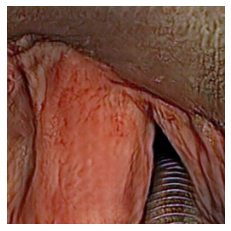

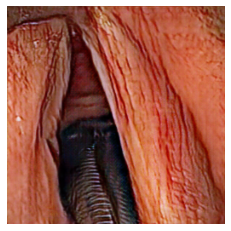

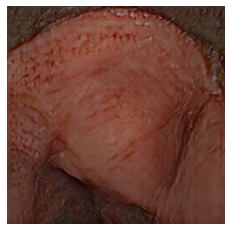

In [ ]:
generate_vocalfolds_images(dcgan_model=dcgan_gen, display=True, 
                          #  save_to_folder=DRIVE_OUTPUT_VOCALFOLDS_DIR, 
                          count=10)

 Generates paired synthetics images  (glotis and mask)

In [ ]:
import random

def generate_paired_images(dcgan_model=dcgan_gen, pix2pix_model=pix2pix_gen, 
                           display=True, save_to_folder="", 
                           count=SYNTHETIC_GENERATE_COUNT):
  """
  Generates paired synthetics images (glotis and mask)
  optionally you can show and save then to a folder
  """
  folder_exists = (save_to_folder != "") and (os.path.isdir(save_to_folder))

  synthentic_glotis_list = generate_synthetic_glotis(dcgan_model, count)

  for glotis in synthentic_glotis_list:
    prediction = pix2pix_model(glotis, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [glotis[0], prediction[0]]
    title = ['Synthetic Glotis', 'Synthetic Mask']

    for i in range(2):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      figure = plt.gcf()

    if display: 
      plt.show()
      

    if folder_exists:
      rnd = random.randint(10000, 99999)
      figure.savefig(save_to_folder + '/gen_paired_imgs_%03d.jpg' % rnd, bbox_inches='tight')

    plt.close()

In [ ]:
generate_paired_images(dcgan_gen, pix2pix_gen, display=True, 
                      #  save_to_folder=DRIVE_OUTPUT_PAIRED_IMAGES_DIR, 
                       count=50)

Output hidden; open in https://colab.research.google.com to view.

Generate synthetic masks

In [ ]:
import random
import os

def generate_synthetic_masks(dcgan_model=dcgan_gen, pix2pix_model=pix2pix_gen, 
                             display=True, save_to_folder="",
                             count=SYNTHETIC_GENERATE_COUNT):
  """
  This method generates synthetics masks from dcgan and pix2pix models
  optionally you can save results to folder and display them
  """
  
  folder_exists = (save_to_folder != "") and (os.path.isdir(save_to_folder))
  
  for i in range(count):
    # Concatenate both models to take sinthetic masks
    gen_output = pix2pix_model(resize_image(dcgan_model(tf.random.normal([1, LATENT_SPACE_DIM]), training=False)), training=True)
    
    if folder_exists:
      rnd = random.randint(10000, 99999)
      keras.preprocessing.image.save_img(save_to_folder + '/gen_mask_%03d.jpg' % rnd, gen_output[0] * 0.5 + 0.5)

    if display:
      plt.imshow(gen_output[0] * 0.5 + 0.5)
      plt.axis('off')
      plt.show()
      plt.close


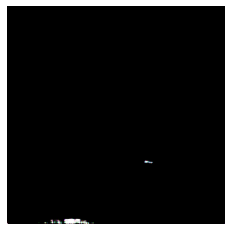

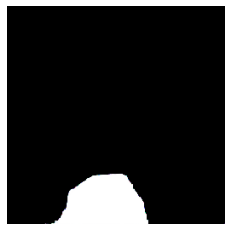

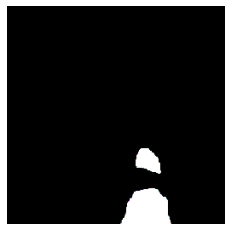

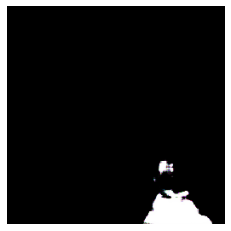

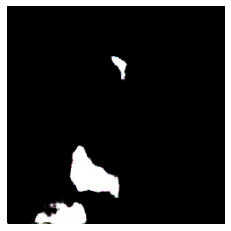

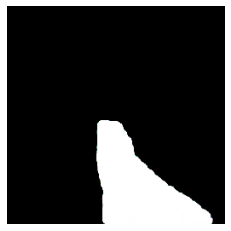

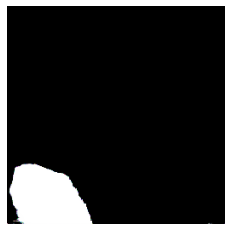

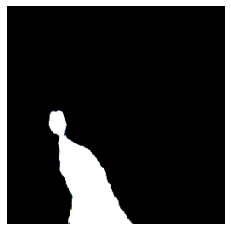

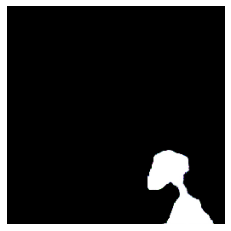

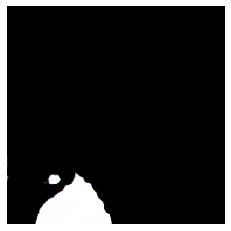

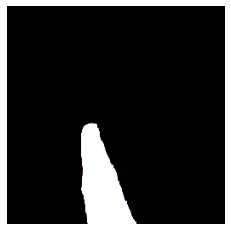

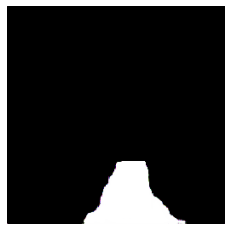

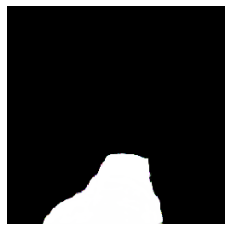

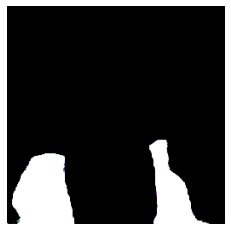

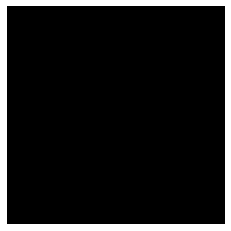

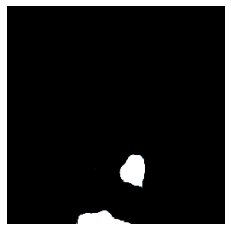

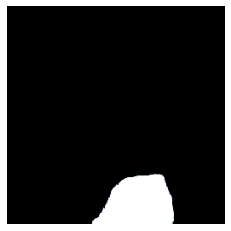

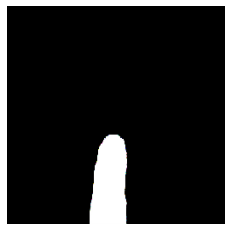

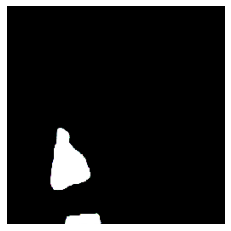

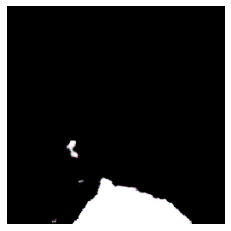

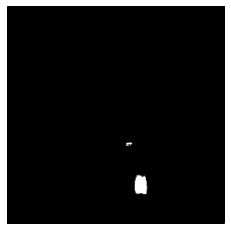

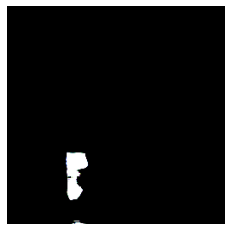

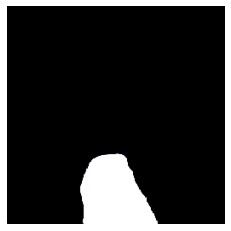

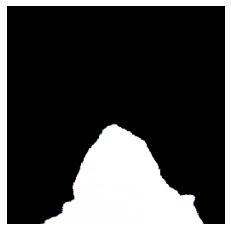

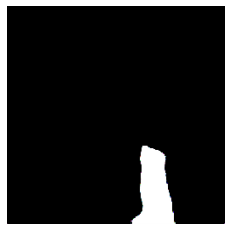

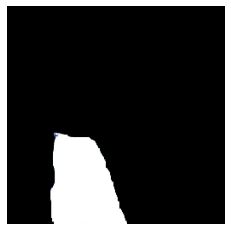

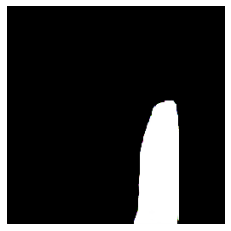

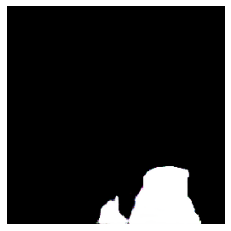

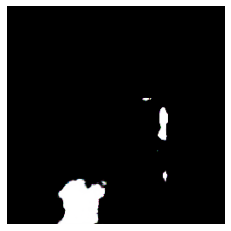

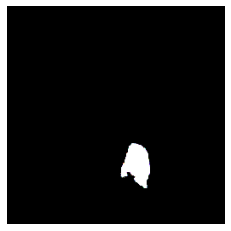

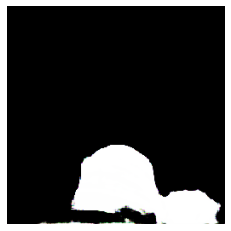

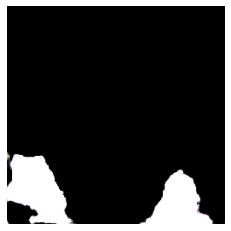

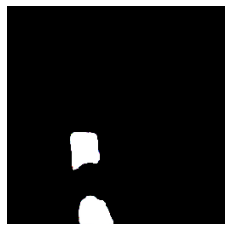

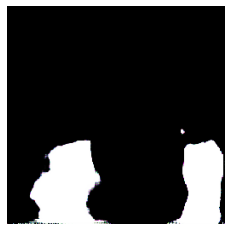

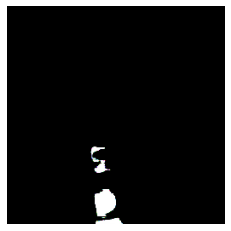

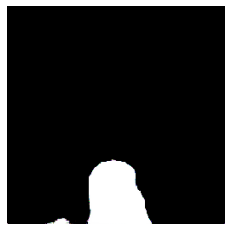

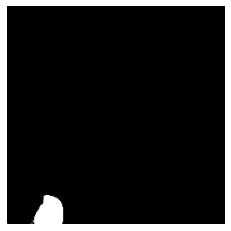

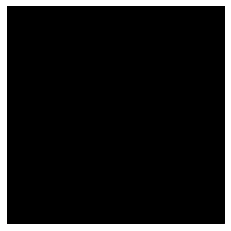

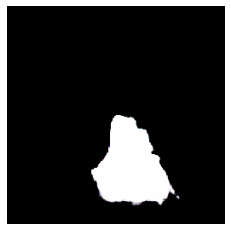

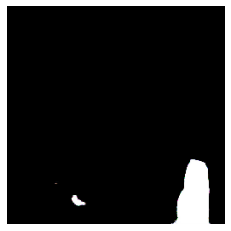

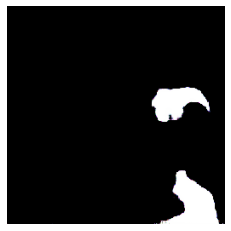

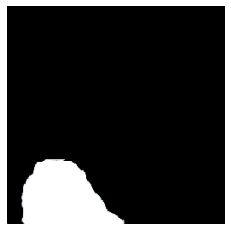

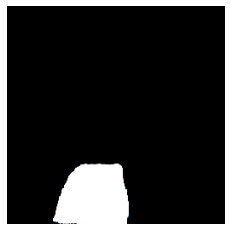

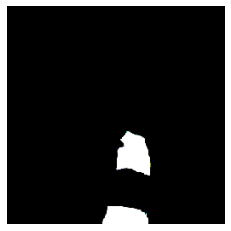

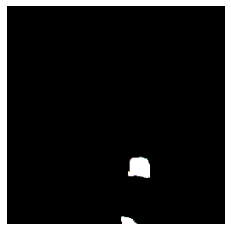

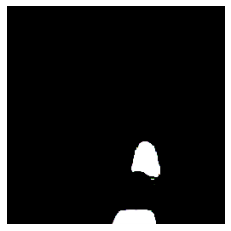

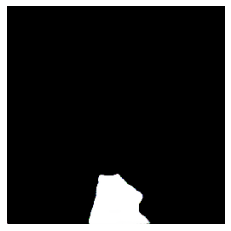

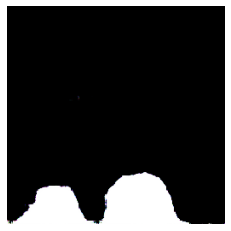

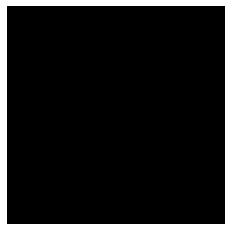

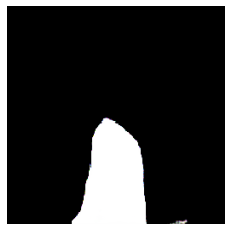

In [ ]:
generate_synthetic_masks(dcgan_gen, pix2pix_gen, display=True, 
                        #  save_to_folder=DRIVE_OUTPUT_MASKS_DIR,
                         count=100)